In [13]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from functools import lru_cache



import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Загрузка данных

In [14]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv('drive/My Drive/NLP/train.csv').drop(['id','keyword', 'location' ], axis = 1)
df_test = pd.read_csv('drive/My Drive/NLP/test.csv').drop(['id','keyword', 'location' ], axis = 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Предобработка данных

## Препроцессор текста

In [15]:
class Text_preproc():
    def __init__(self, language):
        if language == 'english':
            self.bad_reg = re.compile('[^a-z\s\d #]')
            self.stopwords = set(stopwords.words('english'))
            eng_lemmatizer = WordNetLemmatizer()
            @lru_cache(maxsize=10 ** 6)
            def lru_eng_lemmatizer(word):
                return eng_lemmatizer.lemmatize(word)
            self.lemmatizer = lru_eng_lemmatizer
        else:
             raise NotImplementedError('Not supported language')


    def remove_URL(self, text):
        url = re.compile(r'https?://\S+|www\.\S+')
        return url.sub(r'',text)


    def remove_html(self, text):
        html=re.compile(r'<.*?>')
        return html.sub(r'',text)


    def remove_emoji(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)

            
    def __call__(self, text):
        text = self.remove_URL(text)
        text = self.remove_html(text)
        text = self.remove_emoji(text)
        text = text.lower()
        text = re.sub(self.bad_reg, ' ', text)
        text = re.sub('\n|\t', ' ', text)
        text = re.sub(' +', ' ', text)
        lemmas = [self.lemmatizer(word) for word in text.split()]
        lemmas = [word for word in lemmas if word not in self.stopwords]
        
        return ' '.join(lemmas)

In [16]:
preprocessor = Text_preproc('english')

df_train['clear_text'] = df_train['text'].apply(preprocessor)
df_test['clear_text'] = df_test['text'].apply(preprocessor)

df_train.head()

,text,target,clear_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason #earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",1,13 000 people receive #wildfires evacuation or...
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby #alaska smoke #wildfires p...


## Токенизация

In [17]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(df_train['clear_text'].values)
X = tokenizer.texts_to_sequences(df_train['clear_text'].values)
X = pad_sequences(X)

In [18]:
from sklearn.model_selection import train_test_split
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state =42)

In [19]:
l =50
max_features=5000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(df_train['clear_text'].values)
X = tokenizer.texts_to_sequences(df_train['clear_text'].values)
X = pad_sequences(X, maxlen =l)

In [20]:
tokenizer.fit_on_texts(df_train['clear_text'].values)
test_token = tokenizer.texts_to_sequences(df_test['clear_text'].values)
test_token = pad_sequences(test_token, maxlen =l)

# GRU

GRU - управляемый реккурентный блок. GRU можно рассматривать как более простую версию сетей долгой краткосрочной памяти. Он включает в себя много схожих понятий, но имеет куда меньше параметров, а потому при одном и том же размере скрытого слоя обучается быстрее. В то же время управляемый рекуррентный нейрон сложнее.

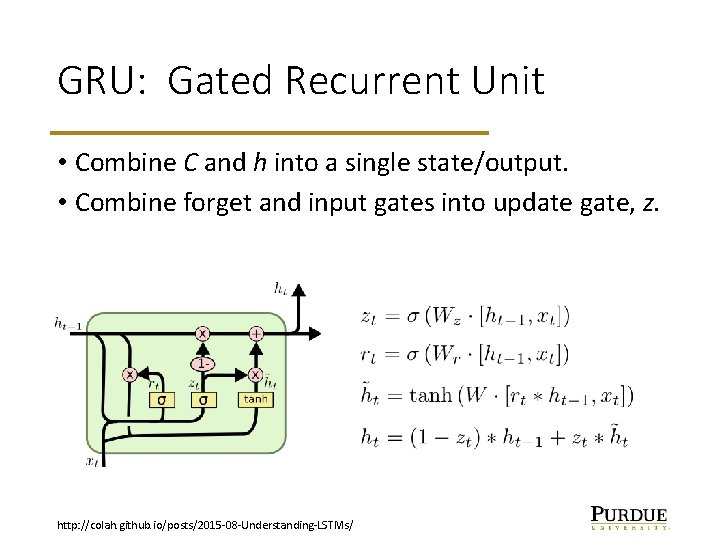

In [21]:
embed_dim = 100
gru_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.4))
model.add(GRU(gru_out, dropout=0.2, return_sequences=True,recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(GRU(gru_out,dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
adam = optimizers.Adam(learning_rate=2e-3)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           500000    
                                                                 
 dropout_3 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_2 (GRU)                 (None, 50, 100)           60600     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_3 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [22]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(X,y, epochs = 1,validation_split = 0.2 ,callbacks=[es_callback], batch_size=32)

191/191 [==============================] - 50s 228ms/step - loss: 0.5332 - accuracy: 0.7414 - val_loss: 0.4403 - val_accuracy: 0.7984


In [23]:
y_hat = model.predict(test_token).round()
submission = pd.read_csv('drive/My Drive/NLP/sample_submission.csv')
submission['target'] = np.round(y_hat).astype('int')
submission.to_csv('submissionGRU.csv', index=False)

In [24]:
from google.colab import files
files.download("submissionGRU.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>